<a href="https://colab.research.google.com/github/rachanashinde15/DemoGIt/blob/master/resnet_thesis_final_3_layerfinaloutput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers


In [ ]:
# Adding TF Cifar10 Data ..
from keras.datasets import cifar100
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 3s 0us/step


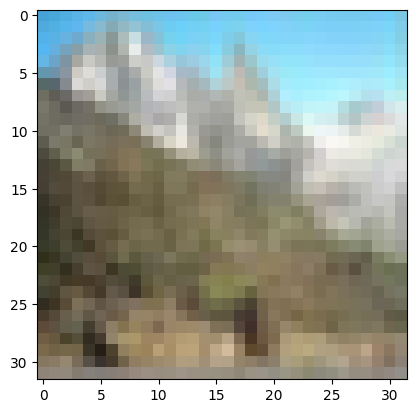

In [ ]:
# Drawing sample . 
plt.imshow(X_train[42])

In [ ]:
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1 = ResnetBlock(64)
        self.res_2 = ResnetBlock(128, down_sample=True)
        self.res_3 = ResnetBlock(256, down_sample=True)
        self.res_4 = ResnetBlock(512, down_sample=True)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)

        # Group the consecutive residual blocks
        out = self.res_1(out)
        out = self.res_2(out)
        out = self.res_3(out)
        out = self.res_4(out)

        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out


In [ ]:
model = ResNet18(100)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple              

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])

Epoch 1/50
157/156 [==============================] - ETA: 0s - loss: 3.5865 - accuracy: 0.1696

156/156 [==============================] - 46s 149ms/step - loss: 3.5865 - accuracy: 0.1696 - val_loss: 5.3657 - val_accuracy: 0.0613
Epoch 2/50
157/156 [==============================] - ETA: 0s - loss: 2.9031 - accuracy: 0.2807

156/156 [==============================] - 22s 140ms/step - loss: 2.9031 - accuracy: 0.2807 - val_loss: 3.0992 - val_accuracy: 0.2473
Epoch 3/50
157/156 [==============================] - ETA: 0s - loss: 2.5719 - accuracy: 0.3414

156/156 [==============================] - 23s 149ms/step - loss: 2.5719 - accuracy: 0.3414 - val_loss: 2.5836 - val_accuracy: 0.3486
Epoch 4/50
157/156 [==============================] - ETA: 0s - loss: 2.3203 - accuracy: 0.3958

156/156 [==============================] - 22s 140ms/step - loss: 2.3203 - accuracy: 0.3958 - val_loss: 2.2690 - val_accuracy: 0.4055
Epoch 5/50
157/156 [==============================] - ETA: 0s - loss: 2.1407 - accuracy: 0.4343

156/156 [==============================] - 22s 138ms/step - loss: 2.1407 - accuracy: 0.4343 - val_loss: 2.2464 - val_accuracy: 0.4111
Epoch 6/50
157/156 [==============================] - ETA: 0s - loss: 1.9606 - accuracy: 0.4742

156/156 [==============================] - 23s 146ms/step - loss: 1.9606 - accuracy: 0.4742 - val_loss: 1.9863 - val_accuracy: 0.4704
Epoch 7/50
157/156 [==============================] - ETA: 0s - loss: 1.7989 - accuracy: 0.5119

156/156 [==============================] - 21s 136ms/step - loss: 1.7989 - accuracy: 0.5119 - val_loss: 1.8346 - val_accuracy: 0.5024
Epoch 8/50
157/156 [==============================] - ETA: 0s - loss: 1.6568 - accuracy: 0.5439

156/156 [==============================] - 21s 137ms/step - loss: 1.6568 - accuracy: 0.5439 - val_loss: 1.7965 - val_accuracy: 0.5102
Epoch 9/50
157/156 [==============================] - ETA: 0s - loss: 1.5240 - accuracy: 0.5762

156/156 [==============================] - 21s 132ms/step - loss: 1.5240 - accuracy: 0.5762 - val_loss: 1.4901 - val_accuracy: 0.5799
Epoch 10/50
157/156 [==============================] - ETA: 0s - loss: 1.3933 - accuracy: 0.6060

156/156 [==============================] - 21s 134ms/step - loss: 1.3933 - accuracy: 0.6060 - val_loss: 1.3442 - val_accuracy: 0.6177
Epoch 11/50
157/156 [==============================] - ETA: 0s - loss: 1.2758 - accuracy: 0.6373

156/156 [==============================] - 22s 141ms/step - loss: 1.2758 - accuracy: 0.6373 - val_loss: 1.5573 - val_accuracy: 0.5648
Epoch 12/50
157/156 [==============================] - ETA: 0s - loss: 1.1465 - accuracy: 0.6698

156/156 [==============================] - 21s 137ms/step - loss: 1.1465 - accuracy: 0.6698 - val_loss: 1.0834 - val_accuracy: 0.6854
Epoch 13/50
157/156 [==============================] - ETA: 0s - loss: 1.0427 - accuracy: 0.6965

156/156 [==============================] - 21s 133ms/step - loss: 1.0427 - accuracy: 0.6965 - val_loss: 1.0608 - val_accuracy: 0.6931
Epoch 14/50
157/156 [==============================] - ETA: 0s - loss: 0.9362 - accuracy: 0.7234

156/156 [==============================] - 21s 134ms/step - loss: 0.9362 - accuracy: 0.7234 - val_loss: 0.7845 - val_accuracy: 0.7690
Epoch 15/50
157/156 [==============================] - ETA: 0s - loss: 0.8349 - accuracy: 0.7542

156/156 [==============================] - 21s 137ms/step - loss: 0.8349 - accuracy: 0.7542 - val_loss: 0.8715 - val_accuracy: 0.7412
Epoch 16/50
157/156 [==============================] - ETA: 0s - loss: 0.7451 - accuracy: 0.7774

156/156 [==============================] - 22s 140ms/step - loss: 0.7451 - accuracy: 0.7774 - val_loss: 0.7124 - val_accuracy: 0.7836
Epoch 17/50
157/156 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.8019

156/156 [==============================] - 22s 140ms/step - loss: 0.6662 - accuracy: 0.8019 - val_loss: 1.0800 - val_accuracy: 0.6897
Epoch 18/50
157/156 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.8137

156/156 [==============================] - 32s 208ms/step - loss: 0.6137 - accuracy: 0.8137 - val_loss: 0.9585 - val_accuracy: 0.7178
Epoch 19/50
157/156 [==============================] - ETA: 0s - loss: 0.5414 - accuracy: 0.8371

156/156 [==============================] - 21s 133ms/step - loss: 0.5414 - accuracy: 0.8371 - val_loss: 0.8197 - val_accuracy: 0.7575
Epoch 20/50
157/156 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.8556

156/156 [==============================] - 27s 173ms/step - loss: 0.4762 - accuracy: 0.8556 - val_loss: 0.8953 - val_accuracy: 0.7408
Epoch 21/50
157/156 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8641

156/156 [==============================] - 23s 144ms/step - loss: 0.4418 - accuracy: 0.8641 - val_loss: 0.7000 - val_accuracy: 0.7909
Epoch 22/50
157/156 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.8770

156/156 [==============================] - 28s 182ms/step - loss: 0.4001 - accuracy: 0.8770 - val_loss: 0.5398 - val_accuracy: 0.8340
Epoch 23/50
157/156 [==============================] - ETA: 0s - loss: 0.3618 - accuracy: 0.8878

156/156 [==============================] - 22s 139ms/step - loss: 0.3618 - accuracy: 0.8878 - val_loss: 0.3180 - val_accuracy: 0.9033
Epoch 24/50
157/156 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8975

156/156 [==============================] - 22s 140ms/step - loss: 0.3325 - accuracy: 0.8975 - val_loss: 0.2969 - val_accuracy: 0.9062
Epoch 25/50
157/156 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.9047

156/156 [==============================] - 22s 144ms/step - loss: 0.3108 - accuracy: 0.9047 - val_loss: 0.2716 - val_accuracy: 0.9157
Epoch 26/50
157/156 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.9095

156/156 [==============================] - 22s 139ms/step - loss: 0.2943 - accuracy: 0.9095 - val_loss: 0.3602 - val_accuracy: 0.8867
Epoch 27/50
157/156 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.9132

156/156 [==============================] - 23s 148ms/step - loss: 0.2765 - accuracy: 0.9132 - val_loss: 0.5265 - val_accuracy: 0.8422
Epoch 28/50
157/156 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.9166

156/156 [==============================] - 21s 137ms/step - loss: 0.2638 - accuracy: 0.9166 - val_loss: 0.5585 - val_accuracy: 0.8289
Epoch 29/50
157/156 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9269

156/156 [==============================] - 21s 135ms/step - loss: 0.2336 - accuracy: 0.9269 - val_loss: 0.5563 - val_accuracy: 0.8284
Epoch 30/50
157/156 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.9257

156/156 [==============================] - 21s 136ms/step - loss: 0.2384 - accuracy: 0.9257 - val_loss: 0.3697 - val_accuracy: 0.8836
Epoch 31/50
157/156 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9315

156/156 [==============================] - 21s 136ms/step - loss: 0.2212 - accuracy: 0.9315 - val_loss: 0.4726 - val_accuracy: 0.8593
Epoch 32/50
157/156 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9295

156/156 [==============================] - 20s 131ms/step - loss: 0.2198 - accuracy: 0.9295 - val_loss: 0.3190 - val_accuracy: 0.8964
Epoch 33/50
157/156 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9360

156/156 [==============================] - 21s 137ms/step - loss: 0.2029 - accuracy: 0.9360 - val_loss: 0.4059 - val_accuracy: 0.8834
Epoch 34/50
157/156 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.9329

156/156 [==============================] - 22s 140ms/step - loss: 0.2131 - accuracy: 0.9329 - val_loss: 0.4360 - val_accuracy: 0.8669
Epoch 35/50
157/156 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9388

156/156 [==============================] - 21s 132ms/step - loss: 0.1941 - accuracy: 0.9388 - val_loss: 0.1724 - val_accuracy: 0.9459
Epoch 36/50
157/156 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9405

156/156 [==============================] - 21s 136ms/step - loss: 0.1900 - accuracy: 0.9405 - val_loss: 0.2413 - val_accuracy: 0.9234
Epoch 37/50
157/156 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9409

156/156 [==============================] - 21s 133ms/step - loss: 0.1843 - accuracy: 0.9409 - val_loss: 0.3427 - val_accuracy: 0.8944
Epoch 38/50
157/156 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.9475

156/156 [==============================] - 21s 137ms/step - loss: 0.1667 - accuracy: 0.9475 - val_loss: 0.2944 - val_accuracy: 0.9053
Epoch 39/50
157/156 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9479

156/156 [==============================] - 21s 137ms/step - loss: 0.1651 - accuracy: 0.9479 - val_loss: 0.1775 - val_accuracy: 0.9434
Epoch 40/50
157/156 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9487

156/156 [==============================] - 22s 139ms/step - loss: 0.1561 - accuracy: 0.9487 - val_loss: 0.2388 - val_accuracy: 0.9226
Epoch 41/50
157/156 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.9396

156/156 [==============================] - 21s 132ms/step - loss: 0.1888 - accuracy: 0.9396 - val_loss: 0.1330 - val_accuracy: 0.9575
Epoch 42/50
157/156 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9477

156/156 [==============================] - 22s 138ms/step - loss: 0.1639 - accuracy: 0.9477 - val_loss: 0.3072 - val_accuracy: 0.9056
Epoch 43/50
157/156 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9429

156/156 [==============================] - 21s 136ms/step - loss: 0.1755 - accuracy: 0.9429 - val_loss: 0.2164 - val_accuracy: 0.9311
Epoch 44/50
157/156 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9523

156/156 [==============================] - 22s 139ms/step - loss: 0.1501 - accuracy: 0.9523 - val_loss: 0.1964 - val_accuracy: 0.9366
Epoch 45/50
157/156 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9533

156/156 [==============================] - 22s 139ms/step - loss: 0.1442 - accuracy: 0.9533 - val_loss: 0.5006 - val_accuracy: 0.8572
Epoch 46/50
157/156 [==============================] - ETA: 0s - loss: 0.1453 - accuracy: 0.9537

156/156 [==============================] - 21s 134ms/step - loss: 0.1453 - accuracy: 0.9537 - val_loss: 0.2455 - val_accuracy: 0.9231
Epoch 47/50
157/156 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9554

156/156 [==============================] - 22s 139ms/step - loss: 0.1380 - accuracy: 0.9554 - val_loss: 0.2687 - val_accuracy: 0.9194
Epoch 48/50
157/156 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9591

156/156 [==============================] - 23s 144ms/step - loss: 0.1259 - accuracy: 0.9591 - val_loss: 0.1285 - val_accuracy: 0.9586
Epoch 49/50
157/156 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9565

156/156 [==============================] - 21s 134ms/step - loss: 0.1364 - accuracy: 0.9565 - val_loss: 0.3086 - val_accuracy: 0.9034
Epoch 50/50
157/156 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9511

156/156 [==============================] - 22s 143ms/step - loss: 0.1518 - accuracy: 0.9511 - val_loss: 0.6316 - val_accuracy: 0.8391


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


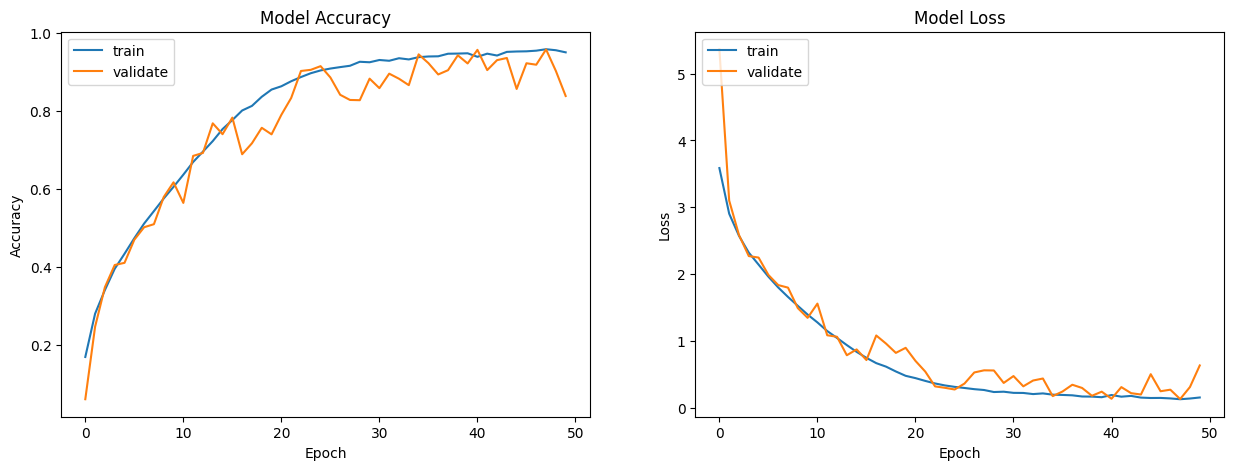

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [ ]:

ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 6s 4ms/step - loss: 0.6316 - accuracy: 0.8391
Model Loss is 0.6316332817077637
Model Accuracy is 0.8391000032424927


In [ ]:
# Assuming you have trained the model and stored it in the 'model' variable
from sklearn.metrics import confusion_matrix
# Make predictions on the test set
Y_pred = model.predict(X_test)
# Convert the one-hot encoded predictions and true labels to their original form
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(Y_true_labels, Y_pred_labels)
print("Confusion Matrix:")
print(confusion_mat)


313/313 [==============================] - 2s 6ms/step
Confusion Matrix:
[[73  0  0 ...  0  0  0]
 [ 0 37  0 ...  0  2  0]
 [ 0  0 23 ...  1  2  0]
 ...
 [ 0  0  2 ... 32  0  1]
 [ 0  0  2 ...  0 17  0]
 [ 0  0  0 ...  0  1 31]]


ValueError: ignored

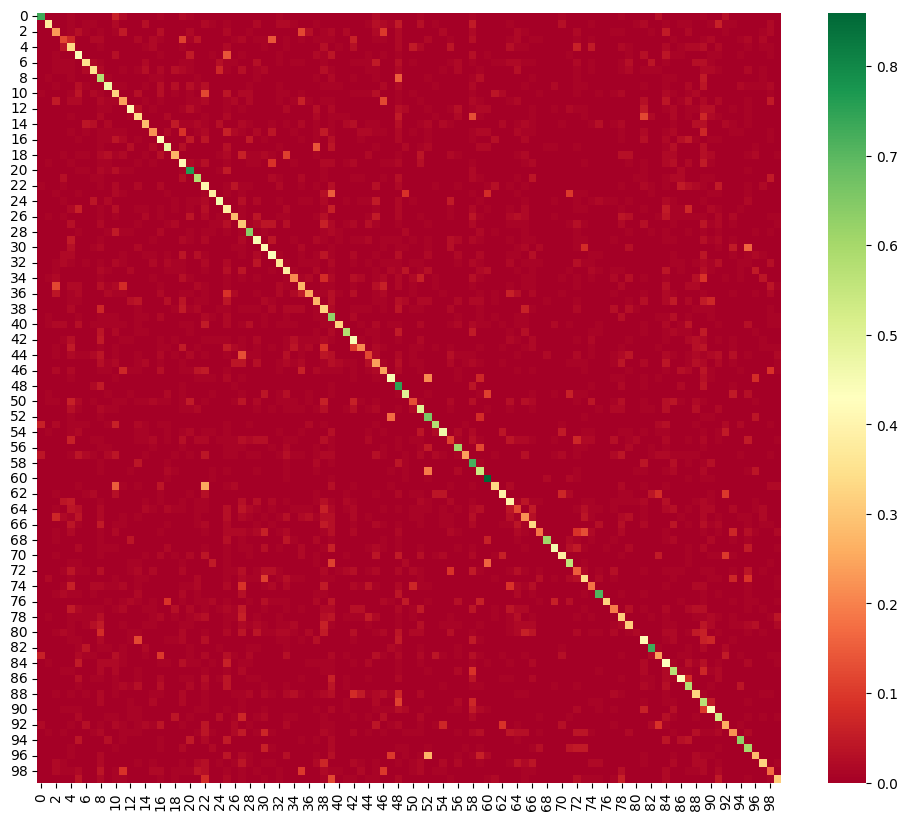

In [ ]:
# Define class labels
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mat, annot=True, cmap='RdYlGn', fmt='d')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have the true labels 'y_true' and predicted labels 'y_pred'

# Generate classification report
report = classification_report(Y_pred_labels,Y_true_labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.73      0.78      0.76        93
           1       0.37      0.73      0.49        51
           2       0.23      0.28      0.25        81
           3       0.12      0.24      0.16        49
           4       0.33      0.22      0.26       151
           5       0.44      0.34      0.38       130
           6       0.35      0.53      0.42        66
           7       0.35      0.49      0.41        72
           8       0.58      0.30      0.39       195
           9       0.47      0.55      0.51        86
          10       0.32      0.24      0.27       135
          11       0.24      0.27      0.25        89
          12       0.41      0.58      0.48        71
          13       0.34      0.33      0.33       104
          14       0.28      0.43      0.34        65
          15       0.22      0.40      0.28        55
          16       0.42      0.35      0.38       119
          17       0.48    